In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pwlf
import pathlib
import math
import numpy as np

In [2]:
src = pathlib.Path().cwd().parent.parent / 'data' / 'processed'

In [3]:
no_death = pd.read_csv(src / 'no-death-from-treatment-data' / 'no-death.csv', index_col=0)

In [4]:
no_death.index = pd.to_datetime(no_death.index)

In [5]:
# no_death.index
no_death.tail()

,no_death,no_death_rollmean7d,no_death_cumsum,no_death_ppop,no_death_ppop_rollmean7d,no_death_ppop_cumsum,ct,diff,pct_change,diff7
date_report,,,,,,,,,,
2021-09-21,184.0,172.142857,12220.0,2.046017,1.914170,135.882226,2.0,25.0,0.157233,1205.0
2021-09-22,181.0,171.000000,12401.0,2.012658,1.901462,137.894884,2.0,-3.0,-0.016304,1197.0
2021-09-23,175.0,173.142857,12576.0,1.945940,1.925289,139.840824,2.0,-6.0,-0.033149,1212.0
2021-09-24,140.0,169.428571,12716.0,1.556752,1.883988,141.397576,2.0,-35.0,-0.200000,1186.0
2021-09-25,123.0,163.428571,12839.0,1.367718,1.817270,142.765294,2.0,-17.0,-0.121429,1144.0


In [23]:
# shift left
# no_case['no_case_rollmean7d_sl'] = no_case.no_case_rollmean7d.shift(-10)
# no_case['no_case_sl'] = no_case.no_case.shift(-10)
# no_case = no_case.loc[:'2021-09-01',]

In [9]:
# no_case.tail(15)
# no_case_by_adh

In [25]:
# Plot no_case
# fig, ax = plt.subplots(figsize=(20, 8))
# ax.plot(no_case.index, no_case.no_case, linewidth=3, color='red', alpha=0.6)
# ax.set_ylabel('Số ca mới')
# ax.set_ylim([0, 7500])
# ax.set_xlabel('Ngày')
# ax.set_xticks(no_case.index)
# ax.tick_params(axis='x', labelrotation=90)

In [26]:
# Plot log no_case
# fig, ax = plt.subplots(figsize=(16, 8))
# ax.plot(no_case.index, (no_case.no_case_rollmean7d).transform(math.log), linewidth=3, color='red', alpha=0.6)
# ax.set_ylabel('Số ca mới')
# # ax.set_ylim([0, 7500])
# ax.set_xlabel('Ngày')
# ax.set_xticks(no_case.index)
# ax.tick_params(axis='x', labelrotation=90)

In [12]:
# Model config
beta_dict = {}
slope_dict = {}
x_dict = {}
y_dict = {}
x_hat_dict = {}
y_hat_dict = {}
predicted_var_dict = {}
ub_dict = {}
lb_dict = {}
xlabels_dict = {}
plot_title_dict = {}
no_death_col = 'no_death_rollmean7d'
forecast_horizon = 10
policy_change = [no_death.index.min(),
#                  '2021-05-31', # chi thi 15, 16
#                  '2021-06-14', # chi thi 15
#                  '2021-06-19', # chi thi 10
#                  '2021-07-09', # chi thi 16
#                  '2021-07-19', # chi thi 16
#                  '2021-07-27', # ngung xn hang loat
#                  '2021-08-01', # chi thi 16
                 '2021-08-10', # quan huyen k fit
                 '2021-08-15',
                 '2021-08-23', # phong toa
                 no_death.index.max()
                ]

In [10]:
# no_death.index - no_death.index.min()

In [13]:
# Forecast no_death
# forecast_horizon = 15
# policy_change = [no_death.index.min(), '2021-05-31', '2021-06-14', '2021-06-19', 
#                  '2021-07-09', '2021-07-19', '2021-08-01', no_death.index.max()]

x = (no_death.index - no_death.index.min()) / pd.Timedelta(1, unit='d')
y = no_death[no_death_col].replace(0, np.nan).transform(math.log).fillna(0)
x0 = (pd.to_datetime(policy_change) - no_death.index.min()) / pd.Timedelta(1, unit='d')
xlabels = pd.date_range(
    no_death.index.min(),
    no_death.index.max() + pd.Timedelta(days=forecast_horizon-1)
).strftime('%d-%m')

model = pwlf.PiecewiseLinFit(x, y)
model.fit_with_breaks(x0)

x_hat = np.arange(min(x), max(x) + forecast_horizon)
y_hat = model.predict(x_hat)

predicted_var = model.prediction_variance(x_hat)
ub = y_hat + 1.96*np.sqrt(predicted_var)
lb = y_hat - 1.96*np.sqrt(predicted_var)

# Add result to dict
beta_dict['tphcm'] = list(model.beta)
slope_dict['tphcm'] = list(model.calc_slopes())
x_dict['tphcm'] = list(x)
y_dict['tphcm'] = list(y)
x_hat_dict['tphcm'] = list(x_hat)
y_hat_dict['tphcm'] = list(y_hat)
predicted_var_dict['tphcm'] = list(predicted_var)
ub_dict['tphcm'] = list(ub)
lb_dict['tphcm'] = list(lb)
xlabels_dict['tphcm'] = list(xlabels)
plot_title_dict['tphcm'] = 'TP HCM'

In [12]:
# dir(model)
# slope_dict
model.r_squared()

0.8719943044914987

In [30]:
# beta_dict['tphcm']

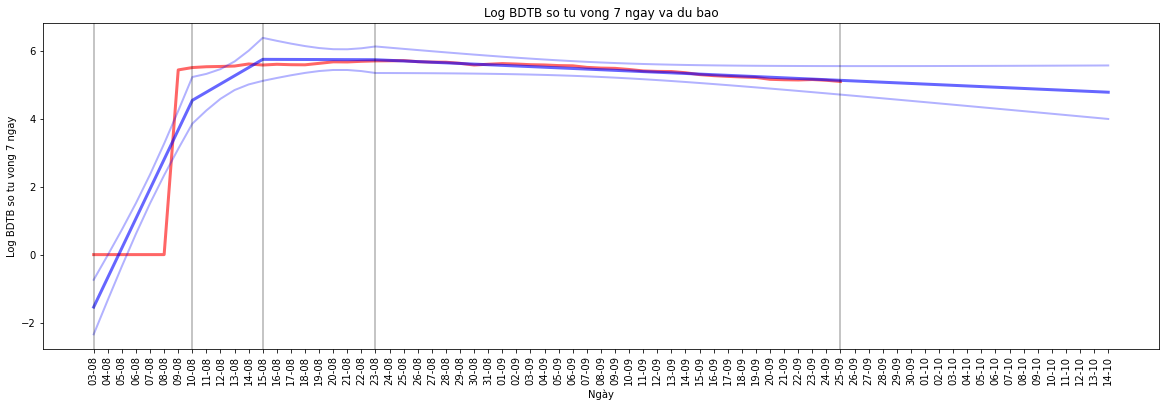

In [13]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(x, y, linewidth=3, color='red', alpha=0.6)
ax.plot(x_hat, y_hat, linewidth=3, color='blue', alpha=0.6)
ax.plot(x_hat, ub, linewidth=2, color='blue', alpha=0.3)
ax.plot(x_hat, lb, linewidth=2, color='blue', alpha=0.3)
ax.set_ylabel('Log BDTB so tu vong 7 ngay')
ax.set_xlabel('Ngày')
ax.set_title('Log BDTB so tu vong 7 ngay va du bao')
for i in x0:
    ax.axvline(i, color='black', alpha=0.3)

xlabels = pd.date_range(
    no_death.index.min(),
    no_death.index.max() + pd.Timedelta(days=forecast_horizon - 1)
).strftime('%d-%m')
ax.set_xticks(x_hat)
ax.set_xticklabels(xlabels)
ax.tick_params(axis='x', labelrotation=90)

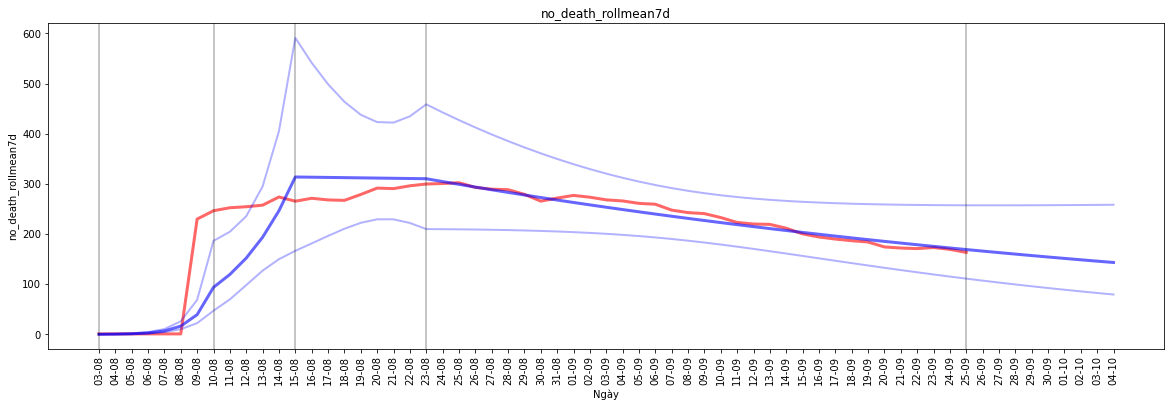

In [14]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(x, np.exp(y), linewidth=3, color='red', alpha=0.6)
# ax.plot(x, no_death.no_death_sl, linewidth=3, color='orange', alpha=0.5)
ax.plot(x_hat,  np.exp(y_hat), linewidth=3, color='blue', alpha=0.6)
ax.plot(x_hat,  np.exp(ub), linewidth=2, color='blue', alpha=0.3)
ax.plot(x_hat,  np.exp(lb), linewidth=2, color='blue', alpha=0.3)
ax.set_ylabel(no_death_col)
ax.set_title(no_death_col)
for i in x0:
    ax.axvline(i, color='black', alpha=0.3)
ax.set_xlabel('Ngày')
xlabels = pd.date_range(
    no_death.index.min(),
    no_death.index.max() + pd.Timedelta(days=forecast_horizon -1 )
).strftime('%d-%m')
ax.set_xticks(x_hat)
ax.set_xticklabels(xlabels)
ax.tick_params(axis='x', labelrotation=90)
ax.locator_params(axis='x', )
# ax.set_ylim([0, 10000])

# plt.savefig(
#     src / 'pwlf-from-no-death-from-treatment-data' / 'no-death.png',
#     transparent = True)
# plt.close(fig)

In [17]:
slope = pd.DataFrame(slope_dict).transpose()
slope.columns = pd.to_datetime(policy_change).strftime('%d-%m-%Y')[:-1]
r0 = np.exp(slope)

slope.to_csv(src / 'pwlf-from-no-death-from-treatment-data' / 'slope.csv')
r0.to_csv(src / 'pwlf-from-no-death-from-treatment-data' / 'r0.csv')
# slope
# r0

In [15]:
# np.exp(y_hat)
np.exp(y_hat)

array([2.13366144e-01, 5.09016250e-01, 1.21433297e+00, 2.89696951e+00,
       6.91114594e+00, 1.64875529e+01, 3.93334772e+01, 9.38357826e+01,
       1.19455479e+02, 1.52070043e+02, 1.93589261e+02, 2.46444343e+02,
       3.13730288e+02, 3.13295681e+02, 3.12861675e+02, 3.12428271e+02,
       3.11995468e+02, 3.11563264e+02, 3.11131658e+02, 3.10700651e+02,
       3.10270241e+02, 3.04617139e+02, 2.99067037e+02, 2.93618057e+02,
       2.88268357e+02, 2.83016129e+02, 2.77859595e+02, 2.72797013e+02,
       2.67826671e+02, 2.62946889e+02, 2.58156015e+02, 2.53452431e+02,
       2.48834546e+02, 2.44300799e+02, 2.39849656e+02, 2.35479612e+02,
       2.31189191e+02, 2.26976940e+02, 2.22841437e+02, 2.18781282e+02,
       2.14795103e+02, 2.10881552e+02, 2.07039305e+02, 2.03267064e+02,
       1.99563552e+02, 1.95927519e+02, 1.92357734e+02, 1.88852990e+02,
       1.85412102e+02, 1.82033907e+02, 1.78717262e+02, 1.75461046e+02,
       1.72264159e+02, 1.69125518e+02, 1.66044063e+02, 1.63018752e+02,
      